<a href="https://colab.research.google.com/github/FaridRasulov/NeuralODE/blob/master/Thesis_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchdiffeq
!pip install pytorch_utils
!pip install tqdm
!pip install adversarial-robustness-toolbox
!pip install kornia

     |████████████████████████████████| 92kB 5.3MB/s 
     |████████████████████████████████| 102kB 6.5MB/s 
     |████████████████████████████████| 163kB 10.8MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
  Created wheel for pytorch-utils: filename=pytorch_utils-0.5.5-cp36-none-any.whl size=14295 sha256=f34c93d52a39b7250fe4653b57b7e6bfd984755a7a7d0e3ca81b5f883dcfb7c3
  Stored in directory: /root/.cache/pip/wheels/fa/c6/30/225a60724bc88f83086829b6047b7b850ff16a8662a7ed280a
  Created wheel for sacred: filename=sacred-0.8.1-py2.py3-none-any.whl size=105018 sha256=019709f70aba7a7b46c3fd572d6b1d89d42c00634653ebeac29d70872170d9b9
  Stored in directory: /root/.cache/pip/wheels/11/a8/f6/1d5f073245cb0a221962713adf81e56c1c9608083f85ecac9b
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20071 sha256=5888ac38c7ec869da1c63afea74f85a5d2563e5d08ead2c741c75ac86c1e6af4
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067

In [3]:
import os
import argparse
import logging
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.nn.functional as F
import torch.optim as optim
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod, CarliniL2Method
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

In [11]:
network = 'odenet' # 'resnet'
tol = 1e-3
adjoint = False # True
downsampling_method = 'conv' # 'res'
nepochs = 2
data_aug = True # False
lr = 0.1
batch_size = 128
test_batch_size = 1000
save = './experiment1'
debug = 'store_true'
gpu = 0

In [12]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)


class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

class ResBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.norm1 = norm(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.norm2 = norm(planes)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        shortcut = x

        out = self.relu(self.norm1(x))

        if self.downsample is not None:
            shortcut = self.downsample(out)

        out = self.conv1(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(out)

        return out + shortcut

class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)

class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out

class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=tol, atol=tol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value


device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
is_odenet = network == 'odenet'

if downsampling_method == 'conv':
        downsampling_layers = [
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        ]
elif downsampling_method == 'res':
        downsampling_layers = [
            nn.Conv2d(1, 64, 3, 1),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
        ]

feature_layers = [ODEBlock(ODEfunc(64))] if is_odenet else [ResBlock(64, 64) for _ in range(6)]
fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]

In [13]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
print('Step 1: Load the MNIST dataset')
# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)
print("Step 1a: Swap axes to PyTorch's NCHW format")

Step 1: Load the MNIST dataset
Step 1a: Swap axes to PyTorch's NCHW format


In [14]:
model_sequenced = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)
model_shuffled = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)

# Step 2a: Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer_sequenced = optim.SGD(model_sequenced.parameters(), lr=0.01)
optimizer_shuffled = optim.SGD(model_shuffled.parameters(), lr=0.01)
print('Step 2a: Define the loss function and the optimizer')
# Step 3: Create the ART classifier



classifier_for_shuffled = PyTorchClassifier(
    model=model_sequenced,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer_shuffled,
    input_shape=(1, 28, 28),
    nb_classes=10,
)
classifier_for_sequenced = PyTorchClassifier(
    model=model_shuffled,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer_sequenced,
    input_shape=(1, 28, 28),
    nb_classes=10,
)
print('Step 3: Create the ART classifier')

Step 2a: Define the loss function and the optimizer
Step 3: Create the ART classifier


In [ ]:
# Step 6: Generate adversarial test examples
attack_sequenced = FastGradientMethod(estimator=classifier_for_sequenced, eps=0.2)
attack_shuffled = FastGradientMethod(estimator=classifier_for_shuffled, eps=0.2)
x_test_adv_sequenced = attack_sequenced.generate(x=x_test)
x_test_adv_shuffled = attack_shuffled.generate(x=x_test)
x_train_adv_sequenced = attack_sequenced.generate(x=x_train)
x_train_adv_shuffled = attack_shuffled.generate(x=x_train)
print('Step 6: Generate adversarial test examples')

In [ ]:
from sklearn.utils import shuffle
sequenced_train_set, sequenced_label_set = np.concatenate((x_train, x_train_adv_sequenced), axis=0), np.concatenate((y_train, y_train), axis=0)
shuffled_train_set, shuffled_label_set = shuffle(np.concatenate((x_train, x_train_adv_shuffled), axis=0), np.concatenate((y_train, y_train), axis=0), random_state=0)
print(sequenced_train_set.shape, sequenced_label_set.shape)
print(shuffled_train_set.shape, shuffled_label_set.shape)

(120000, 1, 28, 28) (120000, 10)
(120000, 1, 28, 28) (120000, 10)


In [ ]:
classifier_for_sequenced.fit(sequenced_train_set, sequenced_label_set, batch_size=64, nb_epochs=nepochs)
print('Trained on an sequenced adv trainset')
classifier_for_shuffled.fit(shuffled_train_set, shuffled_label_set, batch_size=64, nb_epochs=nepochs)
print('Trained on an shuffled adv trainset')

Trained on an sequenced adv trainset
Trained on an shuffled adv trainset


In [ ]:
# Step 7: Evaluate the ART classifier on adversarial test examples
predictions_sequenced = classifier_for_sequenced.predict(x_test_adv_sequenced)
predictions_shuffled = classifier_for_shuffled.predict(x_test_adv_shuffled)
accuracy_sequenced = np.sum(np.argmax(predictions_sequenced, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
accuracy_shuffled = np.sum(np.argmax(predictions_shuffled, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adv sequenced test examples: {}%".format(accuracy_sequenced * 100))
print("Accuracy on adv shuffled test examples: {}%".format(accuracy_shuffled * 100))
print('Step 7: Evaluate the ART classifier on adversarial test examples')

Accuracy on adv sequenced test examples: 98.92999999999999%
Accuracy on adv shuffled test examples: 98.92999999999999%
Step 7: Evaluate the ART classifier on adversarial test examples


In [ ]:
model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

In [ ]:
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=nepochs)

In [ ]:
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

In [ ]:
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(accuracy)

0.3865


In [ ]:
3+5

8

In [1]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip

--2020-10-04 11:48:18--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187490228 (179M) [application/zip]
Saving to: ‘GTSRB-Training_fixed.zip’

GTSRB-Training_fixe 100%[===================>] 178.80M  20.6MB/s    in 9.8s    

2020-10-04 11:48:28 (18.2 MB/s) - ‘GTSRB-Training_fixed.zip’ saved [187490228/187490228]



In [2]:
!unzip GTSRB-Training_fixed.zip

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Training/00030/00007_00025.ppm  
  inflating: GTSRB/Training/00030/00007_00026.ppm  
  inflating: GTSRB/Training/00030/00007_00027.ppm  
  inflating: GTSRB/Training/00030/00007_00028.ppm  
  inflating: GTSRB/Training/00030/00007_00029.ppm  
  inflating: GTSRB/Training/00030/00008_00000.ppm  
  inflating: GTSRB/Training/00030/00008_00001.ppm  
  inflating: GTSRB/Training/00030/00008_00002.ppm  
  inflating: GTSRB/Training/00030/00008_00003.ppm  
  inflating: GTSRB/Training/00030/00008_00004.ppm  
  inflating: GTSRB/Training/00030/00008_00005.ppm  
  inflating: GTSRB/Training/00030/00008_00006.ppm  
  inflating: GTSRB/Training/00030/00008_00007.ppm  
  inflating: GTSRB/Training/00030/00008_00008.ppm  
  inflating: GTSRB/Training/00030/00008_00009.ppm  
  inflating: GTSRB/Training/00030/00008_00010.ppm  
  inflating: GTSRB/Training/00030/00008_00011.ppm  
  inflating: GTSRB/Training/00030/00008_00012.ppm  
  inflating: 

In [3]:
!find ./GTSRB/ -type f | sed -e 's/.*\.//' | sort | uniq -c | sort -n | grep -Ei '(ppm)$'

  26640 ppm


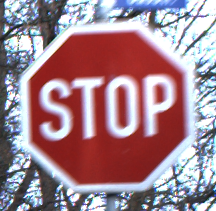

In [65]:
from PIL import Image
img = Image.open("./GTSRB/Training/00014/00013_00029.ppm")
img

In [63]:
for currentpath, folders, files in os.walk('./GTSRB'):
    for file in files:
      if (file.endswith('.ppm'))==False:continue
      img = Image.open(os.path.join(currentpath, file))
      img_size = img.size
      if img_size[0]>200 and img_size[1]>200:
        print(os.path.join(currentpath, file), img_size)
        exec('img')

./GTSRB/Training/00025/00003_00028.ppm (231, 213)
./GTSRB/Training/00025/00022_00029.ppm (218, 201)
./GTSRB/Training/00025/00008_00029.ppm (229, 205)
./GTSRB/Training/00025/00003_00029.ppm (243, 225)
./GTSRB/Training/00011/00002_00029.ppm (216, 203)
./GTSRB/Training/00013/00003_00029.ppm (224, 201)
./GTSRB/Training/00023/00001_00029.ppm (226, 213)
./GTSRB/Training/00014/00013_00029.ppm (216, 211)


In [47]:
!ls ./GTSRB/Training/00034

00000_00000.ppm  00002_00016.ppm  00005_00002.ppm  00007_00018.ppm
00000_00001.ppm  00002_00017.ppm  00005_00003.ppm  00007_00019.ppm
00000_00002.ppm  00002_00018.ppm  00005_00004.ppm  00007_00020.ppm
00000_00003.ppm  00002_00019.ppm  00005_00005.ppm  00007_00021.ppm
00000_00004.ppm  00002_00020.ppm  00005_00006.ppm  00007_00022.ppm
00000_00005.ppm  00002_00021.ppm  00005_00007.ppm  00007_00023.ppm
00000_00006.ppm  00002_00022.ppm  00005_00008.ppm  00007_00024.ppm
00000_00007.ppm  00002_00023.ppm  00005_00009.ppm  00007_00025.ppm
00000_00008.ppm  00002_00024.ppm  00005_00010.ppm  00007_00026.ppm
00000_00009.ppm  00002_00025.ppm  00005_00011.ppm  00007_00027.ppm
00000_00010.ppm  00002_00026.ppm  00005_00012.ppm  00007_00028.ppm
00000_00011.ppm  00002_00027.ppm  00005_00013.ppm  00007_00029.ppm
00000_00012.ppm  00002_00028.ppm  00005_00014.ppm  00008_00000.ppm
00000_00013.ppm  00002_00029.ppm  00005_00015.ppm  00008_00001.ppm
00000_00014.ppm  00003_00000.ppm  00005_00016.ppm  00008_00002